<a href="https://colab.research.google.com/github/JohannesKarwou/notebooks/blob/main/combinedDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import scipy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.legend_handler import HandlerTuple
plt.set_loglevel("WARNING")

In [2]:
# set up color palette
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()

c1, c2, c3, c4, c5, c7 = (
    palett_as_hex[0],
    palett_as_hex[1],
    palett_as_hex[2],
    palett_as_hex[3],
    palett_as_hex[4],
    palett_as_hex[6],
)
c8 = matplotlib.colors.to_rgba("k", alpha=0.1)
c8_2 = matplotlib.colors.to_rgba("k", alpha=0.01)
# c5 = lila
# c7= rosa

In [3]:
data = pd.read_csv("sample_data/combinedDataset.csv")
all_data = pd.read_csv("sample_data/freesolvEXSdata.csv",skiprows=1)
data["MM-ML"]=np.abs(data["MM-ASFE [kcal/mol]"]-data["ML-ASFE [kcal/mol]"])

Wrong direction: 35.48% of 155 compounds


[]

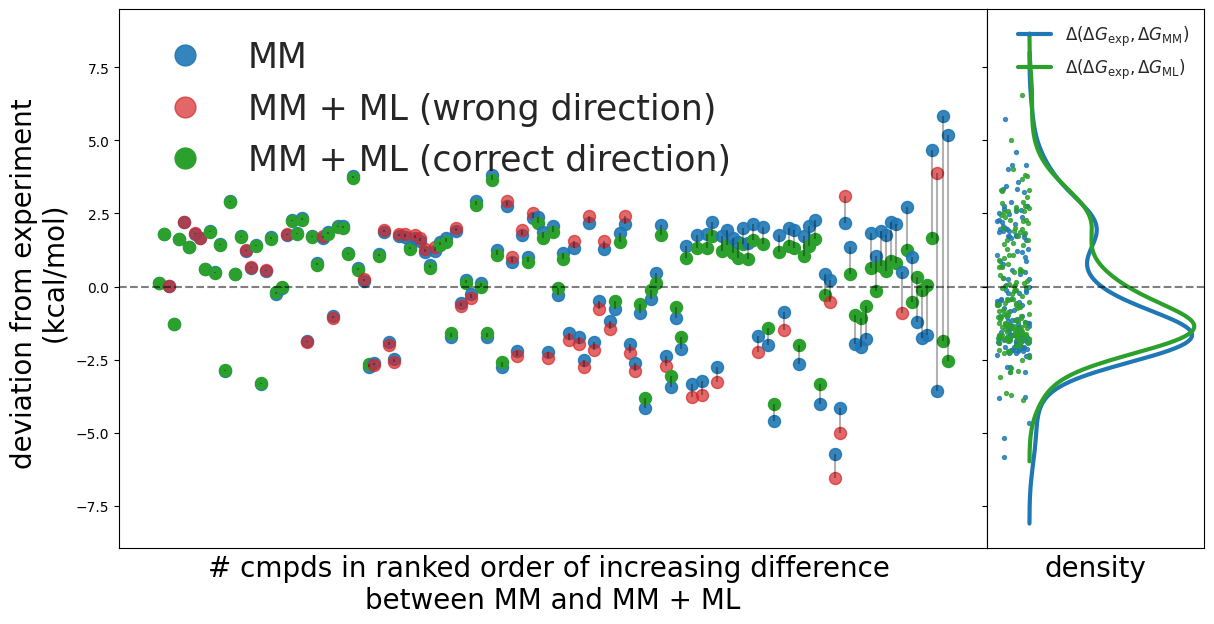

In [4]:
fig, ax = plt.subplots(
    1, 2, figsize=(14, 7), sharey=True, gridspec_kw={"width_ratios": [4, 1]}
)
fig.subplots_adjust(hspace=0, wspace=0)

sns.set_theme(
    style="white",
    rc={
        "font.size": 15,
        "legend.fontsize": 25,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "ytick.left": True,
    },
)

data = data.sort_values(by="MM-ML", ascending=True)

wrong = []
correct = []
for index, row in data.iterrows():
    if not np.isnan(data["Exp [kcal/mol]"][index]):
        noCorrection = np.abs(
            data["Exp [kcal/mol]"][index] - data["MM-ASFE [kcal/mol]"][index]
        )
        corrected = np.abs(
            data["Exp [kcal/mol]"][index]
            - data["ML-ASFE [kcal/mol]"][index]
        )
        if np.abs(data["MM-ML"][index]) > 0.00001:
            ax[0].scatter(
                data["Mol_ID"][index],
                (
                    (data["Exp [kcal/mol]"][index] * -1)
                    + data["MM-ASFE [kcal/mol]"][index]
                ),
                s=75,
                # fmt="o",
                # capsize=3,
                # yerr=data["std (TF)"][index],
                color=c1,
                alpha=0.9,
            )

            if noCorrection >= corrected:
                ax[0].scatter(
                    data["Mol_ID"][index],
                    (
                        (data["Exp [kcal/mol]"][index] * -1)
                        + data["ML-ASFE [kcal/mol]"][index]
                    ),
                    s=75,
                    color=c3,
                )
                correct.append(1)
            else:
                ax[0].scatter(
                    data["Mol_ID"][index],
                    (
                        (data["Exp [kcal/mol]"][index] * -1)
                        + data["ML-ASFE [kcal/mol]"][index]
                    ),
                    s=75,
                    color=c4,
                    alpha=0.7,
                )
                wrong.append(1)

            ax[0].vlines(
                x=data["Mol_ID"][index],
                ymin=(
                    (data["Exp [kcal/mol]"][index] * -1)
                    + data["MM-ASFE [kcal/mol]"][index]
                ),
                ymax=(
                    (data["Exp [kcal/mol]"][index] * -1)
                    + data["ML-ASFE [kcal/mol]"][index]
                ),
                colors="black",
                alpha=0.3,
            )


blue_patch = matplotlib.lines.Line2D(
    [0], [0], marker="o", color=c1, label="MM", ls="None", alpha=0.9, ms=15
)
red_patch = matplotlib.lines.Line2D(
    [0],
    [0],
    marker="o",
    color=c4,
    label="MM + ML (wrong direction)",
    alpha=0.7,
    ls="None",
    ms=15,
)
green_patch = matplotlib.lines.Line2D(
    [0],
    [0],
    marker="o",
    color=c3,
    label="MM + ML (correct direction)",
    ls="None",
    ms=15,
)

ax[0].legend(
    handles=[blue_patch, red_patch, green_patch], frameon=False, loc="upper left"
)


ax[0].axhline(y=0, linestyle="--", color="black",alpha=0.5)
# plt.axhline(y=-2, linestyle="--", color="black")
# plt.axhline(y=2, linestyle="--", color="black")
ax[0].set_xlabel(
    "# cmpds in ranked order of increasing difference \nbetween MM and MM + ML",
    fontsize=20,
)
ax[0].set_ylabel("deviation from experiment \n (kcal/mol)",fontsize=20)
ax[0].set_xticks([])

print(f"Wrong direction: {round(len(wrong)/len(correct+wrong)*100,2)}% of {len(correct+wrong)} compounds")

sns.kdeplot(y=data["Exp [kcal/mol]"]-data["MM-ASFE [kcal/mol]"],color=c1,linewidth=3,label=r'$\Delta(\Delta G_{\mathrm{exp}},\Delta G_{\mathrm{MM}})$',ax=ax[1])
sns.kdeplot(y=data["Exp [kcal/mol]"]-data["ML-ASFE [kcal/mol]"],color=c3,linewidth=3,label=r'$\Delta(\Delta G_{\mathrm{exp}},\Delta G_{\mathrm{ML}})$',ax=ax[1])
ax[1].scatter(
    np.random.uniform(low= -.05, high=0.0, size=len(data["ML-ASFE [kcal/mol]"])),
    data["Exp [kcal/mol]"]-data["MM-ASFE [kcal/mol]"],
    s=8,
    color=c1,
    alpha=0.8,
)
ax[1].scatter(
    np.random.uniform(low= -.05, high=0, size=len(data["ML-ASFE [kcal/mol]"])),
    data["Exp [kcal/mol]"]-data["ML-ASFE [kcal/mol]"],
    s=8,
    color=c3,
    alpha=0.8,
)
ax[1].axhline(0,color="black",linestyle="dashed",alpha=0.5)
ax[1].set_xlabel("density",fontsize=20)
ax[1].legend(fontsize=12,frameon=False,loc='upper right') #,bbox_to_anchor=(1.8, 1.0, 0.0, 0.0))
ax[1].set_xticks([])
# ax[1].spines['right'].set_visible(False)
# ax[1].spines['top'].set_visible(False)

# plt.savefig("overview.png", bbox_inches="tight")

In [5]:
data["EXS correction"] = np.abs(data["ML-ASFE [kcal/mol]"]-data["MM-ASFE [kcal/mol]"])
reduced_data = data.drop(data[np.abs(data['EXS correction']) < 0.5 ].index)
reduced_data = reduced_data.sort_values(by="MM-ML", ascending=True)

In [6]:
reduced_data.loc[:, "correctDirection"] = np.nan
reduced_data.loc[:, "wrongDirection"] = np.nan

for index, row in reduced_data.iterrows():
    if not np.isnan(reduced_data["Exp [kcal/mol]"][index]):
        noCorrection = np.abs(
            reduced_data["Exp [kcal/mol]"][index] - reduced_data["MM-ASFE [kcal/mol]"][index]
        )
        corrected = np.abs(
            reduced_data["Exp [kcal/mol]"][index]
            - reduced_data["ML-ASFE [kcal/mol]"][index]
        )
        if np.abs(reduced_data["MM-ML"][index]) > 0.00001:
            if noCorrection >= corrected: # correct Direction
              # data.loc[index, "correctDirection"] = np.abs(data["ML-ASFE [kcal/mol]"][index]-data["Exp [kcal/mol]"][index])
              reduced_data.loc[index, "correctDirection"] = (reduced_data["ML-ASFE [kcal/mol]"][index]-reduced_data["Exp [kcal/mol]"][index])
              reduced_data.loc[index, "wrongDirection"] = 0
            else:
              reduced_data.loc[index, "correctDirection"] = 0
              # data.loc[index, "wrongDirection"] = np.abs(data["ML-ASFE [kcal/mol]"][index]-data["Exp [kcal/mol]"][index])
              reduced_data.loc[index, "wrongDirection"] = (reduced_data["ML-ASFE [kcal/mol]"][index]-reduced_data["Exp [kcal/mol]"][index])


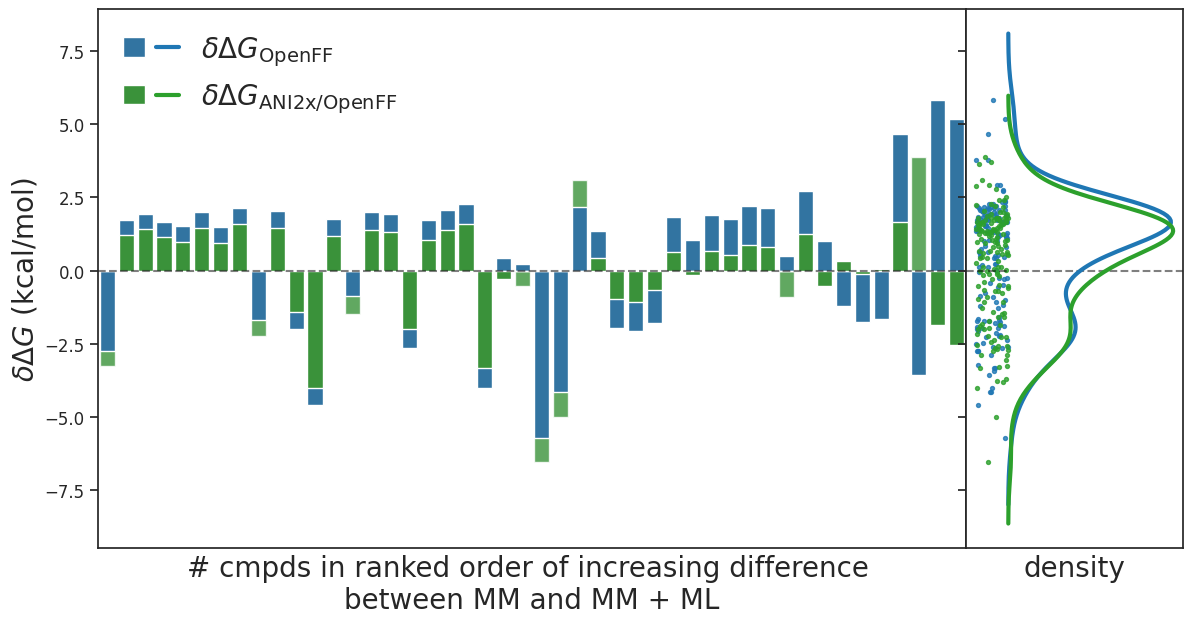

In [7]:
fig, ax = plt.subplots(
    1, 2, figsize=(14, 7), sharey=True, gridspec_kw={"width_ratios": [4, 1]}
)
fig.subplots_adjust(hspace=0, wspace=0.0)

sns.set_theme(
    style="white",
    rc={
        "font.size": 20,
        "legend.fontsize": 25,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 16,
        "ytick.left": True,
    },
)

# sns.barplot(x=data["Mol_ID"],y=np.abs(data["MM-ASFE [kcal/mol]"]-data["Exp [kcal/mol]"]),data=data,label="MM",ec="white", ax=ax[0],color=c1)
sns.barplot(x=reduced_data["Mol_ID"],y=(reduced_data["MM-ASFE [kcal/mol]"]-reduced_data["Exp [kcal/mol]"]),data=reduced_data,label="MM",ec="white", ax=ax[0],color=c1)
sns.barplot(x="Mol_ID",y=reduced_data["correctDirection"],data=reduced_data, ax=ax[0],color=c3,ec="white",label="ML correct")
sns.barplot(x="Mol_ID",y=reduced_data["wrongDirection"],data=reduced_data, ax=ax[0],label="ML wrong",color=c3,ec="white",zorder=0,alpha=0.8)

ax[0].set_ylabel(r"$\delta \Delta G$ (kcal/mol)",fontsize=20)

ax[0].set_xlabel(
    "# cmpds in ranked order of increasing difference \nbetween MM and MM + ML",
    fontsize=20,
)
ax[0].set_xticks([])
ax[0].axhline(0,color="black",linestyle="dashed",alpha=0.5)
ax[1].axhline(0,color="black",linestyle="dashed",alpha=0.5)

sns.kdeplot(y=(data["MM-ASFE [kcal/mol]"]-data["Exp [kcal/mol]"]),color=c1,linewidth=3,label=r'$\Delta(\Delta G_{\mathrm{exp}},\Delta G_{\mathrm{MM}})$',ax=ax[1])
sns.kdeplot(y=(data["ML-ASFE [kcal/mol]"]-data["Exp [kcal/mol]"]),color=c3,linewidth=3,label=r'$\Delta(\Delta G_{\mathrm{exp}},\Delta G_{\mathrm{ML}})$',ax=ax[1])
ax[1].scatter(
    np.random.uniform(low= -.05, high=0.0, size=len(data["ML-ASFE [kcal/mol]"])),
    (data["MM-ASFE [kcal/mol]"]-data["Exp [kcal/mol]"]),
    label="ML",
    s=8,
    color=c1,
    alpha=0.8,
)
ax[1].scatter(
    np.random.uniform(low= -.05, high=0, size=len(data["ML-ASFE [kcal/mol]"])),
    (data["ML-ASFE [kcal/mol]"]-data["Exp [kcal/mol]"]),
    s=8,
    color=c3,
    alpha=0.8,
)

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)  # Adjust the rotation angle as needed
ax[1].set_xticks([])

lines_labels = [axs.get_legend_handles_labels() for axs in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax[0].legend(
    [(lines[0],lines[3]),(lines[1],lines[4])],
    # [r"$\Delta (\Delta \mathrm{G}_{\mathrm{MM}}, \Delta \mathrm{G}_{\mathrm{exp}})$",r"$\Delta (\Delta \mathrm{G}_{\mathrm{MM}},\Delta \mathrm{G}_{\mathrm{exp}} [<|>] \Delta (\Delta \mathrm{G}_{\mathrm{MM}} + \Delta \mathrm{G}^{{corr}}_{\mathrm{ML}}  , \Delta \mathrm{G}_{\mathrm{exp}})$"], #,r"$\Delta \mathrm{G}_{\mathrm{MM}} + \Delta \mathrm{G}^{{corr}}_{\mathrm{ML}} > \Delta(\Delta \mathrm{G}_{\mathrm{MM}}, \Delta \mathrm{G}_{\mathrm{exp}})$"],
    [r'$\delta\Delta G_{\mathrm{OpenFF}}$',r'$\delta\Delta G_{\mathrm{ANI2x/OpenFF}}$'],
    loc="upper left",
    ncol=1,
    frameon=False,
    # bbox_to_anchor=(0.5, -0.1),
    fontsize=20,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)

# ax[0].set_ylim([-7,7])

ax[1].set_xlabel("density",fontsize=20)

plt.savefig("overview.pdf", bbox_inches="tight")

In [8]:
all_data = pd.read_csv("sample_data/freesolvEXSdata.csv",skiprows=1)
all_data["EXS correction"] = np.abs(all_data["ML-ASFE [kcal/mol]"]-all_data["MM-ASFE [kcal/mol]"])
# all_data = all_data.drop(all_data[np.abs(all_data['EXS correction']) < 0.1 ].index)

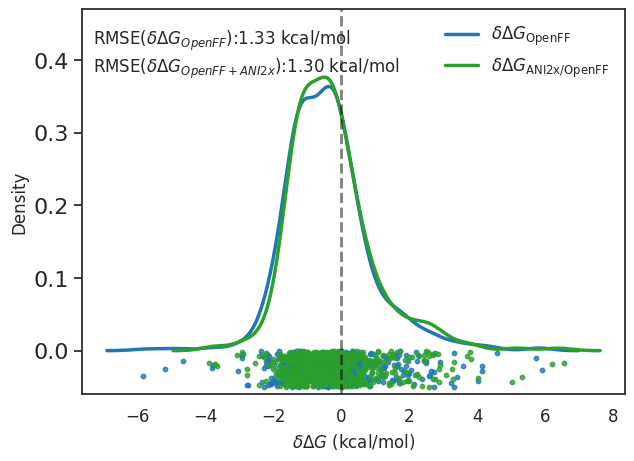

In [9]:
plt.figure(figsize=(7, 5))

sns.kdeplot(data=all_data["Exp [kcal/mol]"]-all_data["MM-ASFE [kcal/mol]"],lw=2.5, c=c1,label=r'$\delta\Delta G_{\mathrm{OpenFF}}$')
sns.kdeplot(data=all_data["Exp [kcal/mol]"]-all_data["ML-ASFE [kcal/mol]"],lw=2.5, c=c3, label=r'$\delta\Delta G_{\mathrm{ANI2x/OpenFF}}$')
plt.axvline(x=0.0, color="black", lw=2,alpha=0.5, ls="--")
plt.scatter(
    all_data["Exp [kcal/mol]"]-all_data["MM-ASFE [kcal/mol]"],
    np.random.uniform(low= -.05, high=0.0, size=len(all_data["ML-ASFE [kcal/mol]"])),
    s=10,
    color=c1,
    alpha=0.8,
)
plt.scatter(
    all_data["Exp [kcal/mol]"]-all_data["ML-ASFE [kcal/mol]"],
    np.random.uniform(low= -.05, high=0, size=len(all_data["ML-ASFE [kcal/mol]"])),
    s=10,
    color=c3,
    alpha=0.8,
)

axs = plt.gca()
rmse_mm = np.sqrt(np.mean((all_data["Exp [kcal/mol]"]-all_data["MM-ASFE [kcal/mol]"])**2))
rmse_qml = np.sqrt(np.mean((all_data["Exp [kcal/mol]"]-all_data["ML-ASFE [kcal/mol]"])**2))

# place a text box in upper left in axes coords
axs.text(0.02, 0.95, f'RMSE$(\delta \Delta G_{{OpenFF}})$:{rmse_mm:.2f} kcal/mol\nRMSE$(\delta \Delta G_{{OpenFF + ANI2x}}$):{rmse_qml:.2f} kcal/mol', transform=axs.transAxes, fontsize=12,
        verticalalignment='top')

plt.ylim([-0.06,0.47])
plt.legend(fontsize=12, frameon=False)
plt.xlabel(r"$\delta \Delta G$ (kcal/mol)")
plt.savefig("KDEallData.pdf",bbox_inches='tight')

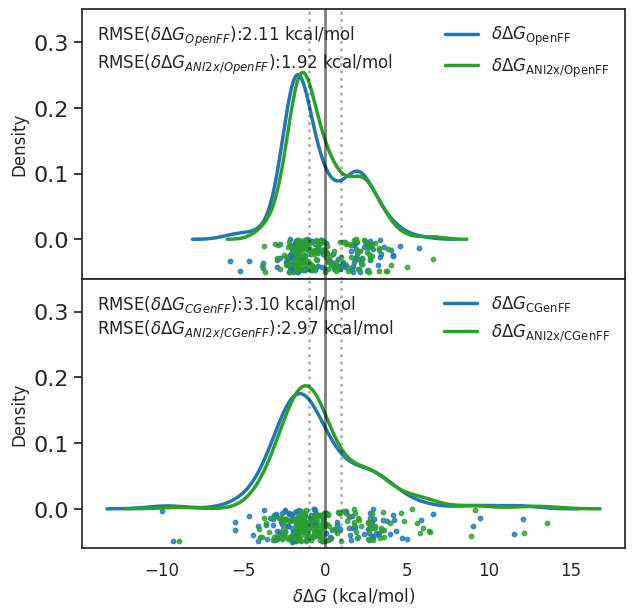

In [37]:
colors = sns.color_palette("flare", n_colors = 201)

fig, ax = plt.subplots(
    2, 1, figsize=(7, 7), sharex=True, sharey=True,
)
fig.subplots_adjust(hspace=0, wspace=0.0)

data["EXS correction"] = np.abs(data["ML-ASFE [kcal/mol]"]-data["MM-ASFE [kcal/mol]"])
# data = data.drop(data[np.abs(data['EXS correction']) < 0.1 ].index)

sns.kdeplot(data=data["Exp [kcal/mol]"]-data["MM-ASFE [kcal/mol]"],lw=2.5,ax=ax[0], c=c1,label=r'$\delta\Delta G_{\mathrm{OpenFF}}$')
sns.kdeplot(data=data["Exp [kcal/mol]"]-data["ML-ASFE [kcal/mol]"],lw=2.5, c=c3,ax=ax[0], label=r'$\delta\Delta G_{\mathrm{ANI2x/OpenFF}}$')

ax[0].axvline(x=-1, color="black", lw=2,alpha=0.3, ls=":")
ax[0].axvline(x=0.0, color="black", lw=2,alpha=0.5, ls="-")
ax[0].axvline(x=1, color="black", lw=2,alpha=0.3, ls=":")

ax[0].scatter(
    data["Exp [kcal/mol]"]-data["MM-ASFE [kcal/mol]"],
    np.random.uniform(low= -.05, high=0.0, size=len(data["ML-ASFE [kcal/mol]"])),
    s=10,
    color=c1,
    alpha=0.8,
)
ax[0].scatter(
    data["Exp [kcal/mol]"]-data["ML-ASFE [kcal/mol]"],
    np.random.uniform(low= -.05, high=0, size=len(data["ML-ASFE [kcal/mol]"])),
    s=10,
    color=c3,
    alpha=0.8,
)

axs = plt.gca()
rmse_mm = np.sqrt(np.mean((data["Exp [kcal/mol]"]-data["MM-ASFE [kcal/mol]"])**2))
rmse_qml = np.sqrt(np.mean((data["Exp [kcal/mol]"]-data["ML-ASFE [kcal/mol]"])**2))


at = AnchoredText(
    f'RMSE$(\delta \Delta G_{{OpenFF}})$:{rmse_mm:.2f} kcal/mol\nRMSE$(\delta \Delta G_{{ANI2x/OpenFF}}$):{rmse_qml:.2f} kcal/mol',
    prop={"fontsize": 12},
    frameon=False,
    loc="upper left",
    # bbox_to_anchor=(0.5, 1.15),
    bbox_transform=ax[0].transAxes,
)
# at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[0].add_artist(at)
ax[0].legend(fontsize=12, frameon=False)

########### Second PLOT - CGENFF ############

sns.kdeplot(data=data["Exp [kcal/mol]"]-data["dG (TF) lrc"],lw=2.5,ax=ax[1], c=c1,label=r'$\delta\Delta G_{\mathrm{CGenFF}}$')
sns.kdeplot(data=data["Exp [kcal/mol]"]-data["Jar result"],lw=2.5, c=c3,ax=ax[1], label=r'$\delta\Delta G_{\mathrm{ANI2x/CGenFF}}$')

ax[1].axvline(x=-1, color="black", lw=2,alpha=0.3, ls=":")
ax[1].axvline(x=0.0, color="black", lw=2,alpha=0.5, ls="-")
ax[1].axvline(x=1, color="black", lw=2,alpha=0.3, ls=":")

ax[1].scatter(
    data["Exp [kcal/mol]"]-data["dG (TF) lrc"],
    np.random.uniform(low= -.05, high=0.0, size=len(data["Jar result"])),
    s=10,
    color=c1,
    alpha=0.8,
)
ax[1].scatter(
    data["Exp [kcal/mol]"]-data["Jar result"],
    np.random.uniform(low= -.05, high=0, size=len(data["Jar result"])),
    s=10,
    color=c3,
    alpha=0.8,
)

axs = plt.gca()
rmse_mm = np.sqrt(np.mean((data["Exp [kcal/mol]"]-data["dG (TF) lrc"])**2))
rmse_qml = np.sqrt(np.mean((data["Exp [kcal/mol]"]-data["Jar result"])**2))


at = AnchoredText(
    f'RMSE$(\delta \Delta G_{{CGenFF}})$:{rmse_mm:.2f} kcal/mol\nRMSE$(\delta \Delta G_{{ANI2x/CGenFF}}$):{rmse_qml:.2f} kcal/mol',
    prop={"fontsize": 12},
    frameon=False,
    loc="upper left",
    # bbox_to_anchor=(0.5, 1.15),
    bbox_transform=ax[1].transAxes,
)
# at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[1].add_artist(at)

plt.ylim([-0.06,0.35])
ax[1].legend(fontsize=12, frameon=False)
ax[1].set_xlabel(r"$\delta \Delta G$ (kcal/mol)")
plt.savefig("KDEcombined.pdf",bbox_inches='tight')

In [11]:
len(all_data)

589

In [12]:
def bootstrap_metric(fct, x_values, y_values, p_value=False):
    bootstrapped_metric = []
    # bootstrap metric to generate test distribution
    for _ in range(1000):
        indices = np.random.choice(
            range(0, len(x_values)), size=len(x_values), replace=True
        )
        x_selection = np.take(x_values, indices)
        y_selection = np.take(y_values, indices)
        if p_value:
            r = fct(x_selection, y_selection)[0]
        else:
            r = fct(x_selection, y_selection)
        bootstrapped_metric.append(r)

    # define 95% CI
    alpha = 5.0
    lower_p = alpha / 2.0
    # get value at or near percentile (take a look at the definition of percentile if
    # you have less than 100 values to make sure you understand what is happening)
    lower = np.percentile(bootstrapped_metric, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = np.percentile(bootstrapped_metric, upper_p)
    # calculate true mean
    if p_value:
        mean = fct(x_values, y_values)[0]
    else:
        mean = fct(x_values, y_values)
    return mean, lower, upper

def calculate_statistics(x_values, y_values,output=False):
    # bootstrap RMSE
    def calc_rmse(x_values, y_values):
        return np.sqrt(mean_squared_error(x_values, y_values))

    rmse_mean, rmse_lower, rmse_upper = bootstrap_metric(calc_rmse, x_values, y_values)
    if output:
      print(
        f"RMSE:  {round(rmse_mean, 2)} [{round(rmse_lower,2)}, {round(rmse_upper,2)}]"
      )

    # bootstrap MAE
    mae_mean, mae_lower, mae_upper = bootstrap_metric(
        mean_absolute_error, x_values, y_values
    )
    if output:
      print(f"MAE:  {round(mae_mean, 2)} [{round(mae_lower,2)}, {round(mae_upper,2)}]")

    # bootstrap Pearson
    pearson_mean, pearson_lower, pearson_upper = bootstrap_metric(
        scipy.stats.pearsonr, x_values, y_values, p_value=True
    )
    if output:
      print(
          f"Pearson correlation:  {round(pearson_mean, 2)} [{round(pearson_lower,2)}, {round(pearson_upper,2)}]"
      )

    # bootstrap Spearman
    spearman_mean, spearman_lower, spearman_upper = bootstrap_metric(
        scipy.stats.spearmanr, x_values, y_values, p_value=True
    )
    if output:
      print(
          f"Spearman's correlation:  {round(spearman_mean, 2)} [{round(spearman_lower,2)}, {round(spearman_upper,2)}]"
      )

    # bootstrap Kendalltau
    kendall_mean, kendall_lower, kendall_upper = bootstrap_metric(
        scipy.stats.kendalltau, x_values, y_values, p_value=True
    )
    if output:
      print(
          f"Kendalltau: {round(kendall_mean, 2)} [{round(kendall_lower,2)}, {round(kendall_upper,2)}]"
      )

    return (
        round(rmse_mean, 2),
        round(mae_mean, 2),
        round(pearson_mean, 2),
        round(spearman_mean, 2),
        round(kendall_mean, 2),
    )

Results for the **OpenFF** data

In [13]:
print(f"###### Without Corretion -- pure MM results ######")
calculate_statistics(data["Exp [kcal/mol]"],data["MM-ASFE [kcal/mol]"],output=True)
print(f"###### Corrected results ######")
calculate_statistics(data["Exp [kcal/mol]"],data["ML-ASFE [kcal/mol]"],output=True)

###### Without Corretion -- pure MM results ######
RMSE:  2.11 [1.91, 2.3]
MAE:  1.83 [1.68, 2.01]
Pearson correlation:  0.9 [0.88, 0.92]
Spearman's correlation:  0.91 [0.88, 0.93]
Kendalltau: 0.75 [0.7, 0.79]
###### Corrected results ######
RMSE:  1.92 [1.71, 2.13]
MAE:  1.61 [1.46, 1.79]
Pearson correlation:  0.93 [0.9, 0.96]
Spearman's correlation:  0.92 [0.89, 0.95]
Kendalltau: 0.76 [0.72, 0.8]


(1.92, 1.61, 0.93, 0.92, 0.76)

Results for the **CGenFF** data

In [14]:
print(f"###### Without Corretion -- pure MM results ######")
calculate_statistics(data["Exp [kcal/mol]"],data["dG (TF) lrc"],output=True)
print(f"###### Corrected results Jar ######")
calculate_statistics(data["Exp [kcal/mol]"],data["Jar result"],output=True)

###### Without Corretion -- pure MM results ######
RMSE:  3.1 [2.61, 3.62]
MAE:  2.33 [2.02, 2.67]
Pearson correlation:  0.77 [0.7, 0.83]
Spearman's correlation:  0.76 [0.66, 0.85]
Kendalltau: 0.6 [0.51, 0.68]
###### Corrected results Jar ######
RMSE:  2.97 [2.38, 3.54]
MAE:  2.14 [1.84, 2.51]
Pearson correlation:  0.81 [0.72, 0.88]
Spearman's correlation:  0.76 [0.65, 0.84]
Kendalltau: 0.6 [0.51, 0.68]


(2.97, 2.14, 0.81, 0.76, 0.6)

In [15]:
data["EXS correction"] = np.abs(data["ML-ASFE [kcal/mol]"]-data["MM-ASFE [kcal/mol]"])


In [16]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}
mae_results = {}
mae_results_cgenff = {}
mae_results_cgenff_crooks = {}
for i in range(0,6,1):
  i = i/10
  reducedData = data.drop(data[np.abs(data['EXS correction']) < i ].index)
  reducedData = reducedData.drop(reducedData[np.abs(reducedData['Jar correction']) < i ].index)
  ###### Without Corretion -- pure MM results ######
  rmse0,mae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["MM-ASFE [kcal/mol]"])
  Crmse0,Cmae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["dG (TF) lrc"])
  ###### Corrected results ######
  rmse1,mae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["ML-ASFE [kcal/mol]"])
  Crmse1,Cmae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Jar result"])
  CrooksRmse1,CrooksMae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Crooks result"])
  results[i] = rmse0-rmse1,len(reducedData)
  results_cgenff[i] = Crmse0-Crmse1,len(reducedData)
  results_cgenff_crooks[i] = Crmse0 - CrooksRmse1
  mae_results[i] = mae0-mae1,len(reducedData)
  mae_results_cgenff[i] = Cmae0-Cmae1,len(reducedData)
  mae_results_cgenff_crooks[i] = Cmae0 - CrooksMae1

Text(0.5, 1.0, 'MAE')

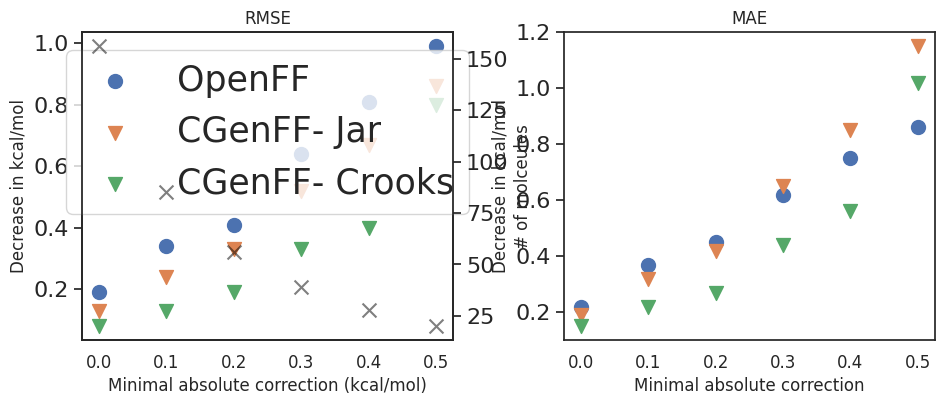

In [17]:
fig, ax1 = plt.subplots(1,2, figsize=(11, 4),sharex=True)
fig.subplots_adjust(wspace=0.3)
ax1[0].scatter(results.keys(),[item[0] for item in results.values()], label = "OpenFF")
ax1[0].scatter(results_cgenff.keys(),[item[0] for item in results_cgenff.values()],marker ="v", label = "CGenFF- Jar")
ax1[0].scatter(results_cgenff_crooks.keys(),results_cgenff_crooks.values(), marker = "v", label = "CGenFF- Crooks")
ax1[0].set_ylabel("Decrease in kcal/mol")
ax1[0].set_title("RMSE")
ax1[0].set_xlabel("Minimal absolute correction (kcal/mol)")
ax2 = ax1[0].twinx()
ax2.scatter(results.keys(),[item[1] for item in results.values()],marker="x",color="black",label="# of molecules",alpha=0.5)
ax2.set_ylabel("# of molceules")
ax1[0].legend(frameon=True,loc="upper center")

ax1[1].scatter(mae_results.keys(),[item[0] for item in mae_results.values()], label = "OpenFF")
ax1[1].scatter(mae_results_cgenff.keys(),[item[0] for item in mae_results_cgenff.values()],marker ="v", label = "CGenFF- Jar")
ax1[1].scatter(mae_results_cgenff_crooks.keys(),mae_results_cgenff_crooks.values(), marker = "v", label = "CGenFF- Crooks")
ax1[1].set_ylabel("Decrease in kcal/mol")
ax1[1].set_xlabel("Minimal absolute correction")
ax1[1].set_title("MAE")

In [18]:
!pip install rdkit

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import OrderedDict
import numpy as np
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import rdDistGeom, rdForceFieldHelpers

In [20]:
def GenerateConformers(mol, numConfs):
    # Add Hydrogens to the skeleton
    molecule = Chem.AddHs(mol)

    conformerIntegers = []

    # Embed and optimize the conformers
    conformers = rdDistGeom.EmbedMultipleConfs(molecule, numConfs, pruneRmsThresh=0.5, numThreads=8)
    optimized_and_energies =  rdForceFieldHelpers.MMFFOptimizeMoleculeConfs(molecule, maxIters=600, numThreads=8, nonBondedThresh=100.0)

    EnergyDictionaryWithIDAsKey = {}
    FinalConformersToUse = {}

    # Only keep the conformers which were successfully fully optimized
    for conformer in conformers:
        optimized, energy = optimized_and_energies[conformer]
        if optimized == 0:
            EnergyDictionaryWithIDAsKey[conformer] = energy
            conformerIntegers.append(conformer)

    # Keep the lowest energy conformer
    lowestEnergy = min(EnergyDictionaryWithIDAsKey.values())

    for k, v in EnergyDictionaryWithIDAsKey.items():
        if v == lowestEnergy:
            lowestEnergyConformerID = k

    FinalConformersToUse[lowestEnergyConformerID] = lowestEnergy

    # Remove Hydrogens to speed up substructure matching
    molecule = AllChem.RemoveHs(molecule)

    # Find all substructure matches of the molecule with itself, to account for symmetry
    matches = molecule.GetSubstructMatches(molecule, uniquify=False)
    maps = [list(enumerate(match)) for match in matches]

    # Loop over conformers other than the lowest energy one
    for conformerID in EnergyDictionaryWithIDAsKey.keys():
        okayToAdd = True

        # Loop over reference conformers already added to list
        for finalConformerID in FinalConformersToUse.keys():

            # Calculate the best RMS of this conformer with the reference conformer in the list
            RMS = AllChem.GetBestRMS(molecule, molecule, finalConformerID, conformerID, maps)

            # Do not add if a match is found with a reference conformer
            if RMS < 1.0:
                okayToAdd = False
                break

        # Add the conformer if the RMS is greater than 1.0 for every reference conformer
        if okayToAdd:
            FinalConformersToUse[conformerID] = EnergyDictionaryWithIDAsKey[conformerID]

    # Sort the conformers by energy
    sortedDictionary = OrderedDict(sorted(FinalConformersToUse.items(), key=lambda t: t[1]))

    energies = [val for val in sortedDictionary.values()]

    return energies

def CalcConf20(energyList):
    energyDescriptor = 0

    relativeEnergies = np.array(energyList) - energyList[0]

    # Only look at the energies of conformers other than the global minimum
    for energy in relativeEnergies[1:]:
        # Optimize lower and upper energy limits for conformer energy
        if 0 <= energy < 20:
            energyDescriptor += 1

    return energyDescriptor


def CalcConf20(molecule):

    energyList = GenerateConformers(molecule, 100)
    energyDescriptor = 0

    relativeEnergies = np.array(energyList) - energyList[0]

    # Only look at the energies of conformers other than the global minimum
    for energy in relativeEnergies[1:]:
        # Optimize lower and upper energy limits for conformer energy
        if 0 <= energy < 20:
            energyDescriptor += 1

    return energyDescriptor


In [21]:
data["MM-ML"] = np.abs(data["MM-ASFE [kcal/mol]"]-data["ML-ASFE [kcal/mol]"])

In [22]:
data.loc[:, "numRotBonds"] = np.nan
data.loc[:, "hallkier"] = np.nan
data.loc[:, "conf20"] = np.nan

numRotBonds = {}
for index, row in data.iterrows():
    try:
      smi = row[" SMILES"].strip()
      correction = row["MM-ML"]
      mol = Chem.MolFromSmiles(smi)
      # display(mol)
      rotBonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
      hallkier = GraphDescriptors.HallKierAlpha(mol)
      conf20 = CalcConf20(mol)
      data.loc[index, "numRotBonds"] = rotBonds
      data.loc[index, "hallkier"] = hallkier
      data.loc[index, "conf20"] = conf20
      # print(rotBonds)
      try:
          numRotBonds[rotBonds].append(correction)

      except KeyError:
          numRotBonds[rotBonds] = []
          numRotBonds[rotBonds].append(correction)
    except AttributeError:
      pass

In [23]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}
mae_results = {}
mae_results_cgenff = {}
mae_results_cgenff_crooks = {}
for i in range(0,8):
  reducedData = data.drop(data[data['numRotBonds'] < i ].index)
  reducedData = reducedData.drop(reducedData[np.abs(reducedData['Jar correction']) < 0.1 ].index)
  reducedData = reducedData.drop(reducedData[np.abs(reducedData['EXS correction']) < 0.1 ].index)
  ###### Without Corretion -- pure MM results ######
  rmse0,mae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["MM-ASFE [kcal/mol]"])
  Crmse0,Cmae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["dG (TF) lrc"])
  ###### Corrected results ######
  rmse1,mae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["ML-ASFE [kcal/mol]"])
  Crmse1,Cmae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Jar result"])
  CrooksRmse1,CrooksMae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Crooks result"])
  mae_results[i] = mae0-mae1,len(reducedData)
  mae_results_cgenff[i] = Cmae0-Cmae1,len(reducedData)
  mae_results_cgenff_crooks[i] = Cmae0 - CrooksMae1
  results[i] = rmse0-rmse1,len(reducedData)
  results_cgenff[i] = rmse0-Crmse1,len(reducedData)
  results_cgenff_crooks[i] = Crmse0 - CrooksRmse1

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlati

Text(0.5, 1.0, 'MAE')

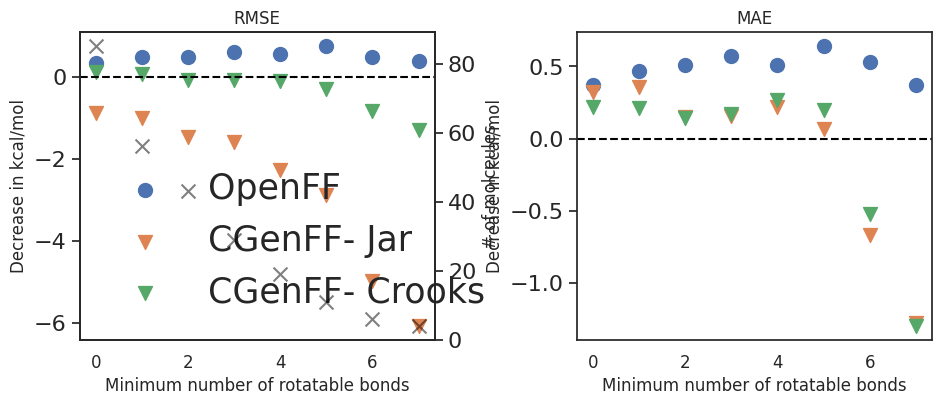

In [24]:
fig, ax1 = plt.subplots(1,2, figsize=(11, 4),sharex=True)
fig.subplots_adjust(wspace=0.4)
ax1[0].scatter(results.keys(),[item[0] for item in results.values()], label = "OpenFF")
ax1[0].scatter(results_cgenff.keys(),[item[0] for item in results_cgenff.values()],marker ="v", label = "CGenFF- Jar")
ax1[0].scatter(results_cgenff_crooks.keys(),results_cgenff_crooks.values(), marker = "v", label = "CGenFF- Crooks")
ax1[0].set_ylabel("Decrease in kcal/mol")
ax1[0].set_title("RMSE")
ax1[0].set_xlabel("Minimum number of rotatable bonds")
ax2 = ax1[0].twinx()
ax2.scatter(results.keys(),[item[1] for item in results.values()],marker="x",color="black",label="# of molecules",alpha=0.5)
ax2.set_ylabel("# of molceules")
ax1[0].axhline(0,color="black",linestyle="dashed")
ax1[0].legend(frameon=False,loc="lower left")

ax1[1].scatter(mae_results.keys(),[item[0] for item in mae_results.values()], label = "OpenFF")
ax1[1].scatter(mae_results_cgenff.keys(),[item[0] for item in mae_results_cgenff.values()],marker ="v", label = "CGenFF- Jar")
ax1[1].scatter(mae_results_cgenff_crooks.keys(),mae_results_cgenff_crooks.values(), marker = "v", label = "CGenFF- Crooks")
ax1[1].set_ylabel("Decrease in kcal/mol")
ax1[1].axhline(0,color="black",linestyle="dashed")
ax1[1].set_xlabel("Minimum number of rotatable bonds")
ax1[1].set_title("MAE")

In [25]:
mae_results_cgenff

{0: (0.31999999999999984, 85),
 1: (0.3599999999999999, 56),
 2: (0.1499999999999999, 43),
 3: (0.1599999999999997, 29),
 4: (0.2200000000000002, 19),
 5: (0.07000000000000028, 11),
 6: (-0.6699999999999999, 6),
 7: (-1.2800000000000002, 4)}

In [26]:
reduced_data = data.drop(data[data['numRotBonds'] < 5 ].index)
reducedData = reducedData.drop(reducedData[np.abs(reducedData['Jar correction']) < 0.1 ].index)
reducedData = reducedData.drop(reducedData[np.abs(reducedData['EXS correction']) < 0.1 ].index)
rmse0,mae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["MM-ASFE [kcal/mol]"])
Crmse0,Cmae0,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["dG (TF) lrc"])
###### Corrected results ######
rmse1,mae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["ML-ASFE [kcal/mol]"])
Crmse1,Cmae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Jar result"])
CrooksRmse1,CrooksMae1,_,_,_ = calculate_statistics(reducedData["Exp [kcal/mol]"],reducedData["Crooks result"])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlati

In [27]:
Cmae0 -Cmae1

-1.2800000000000002

In [28]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}

for i in range(0,6,1):
  i = i/10
  reducedData = data.drop(data[np.abs(data['EXS correction']) < i ].index)
# for i in range(0,8):
#   reducedData = data.drop(data[data['numRotBonds'] < i ].index)

  rightDirection = 0
  wrongDirection = 0

  for index,row in reducedData.iterrows():
    deviation_mm = (np.abs(row["MM-ASFE [kcal/mol]"]-row["Exp [kcal/mol]"]))
    deviation_corrected = (np.abs(row["ML-ASFE [kcal/mol]"]-row["Exp [kcal/mol]"]))
    if deviation_mm > deviation_corrected:
      rightDirection += 1
    else:
      wrongDirection += 1

    results[i] = round(rightDirection/(rightDirection+wrongDirection)*100,2)

    rightDirection = 0
    wrongDirection = 0

    for index,row in reducedData.iterrows():
      deviation_mm = (np.abs(row["dG (TF) lrc"]-row["Exp [kcal/mol]"]))
      deviation_corrected = (np.abs(row["Jar result"]-row["Exp [kcal/mol]"]))
      if deviation_mm > deviation_corrected:
        rightDirection += 1
      else:
        wrongDirection += 1

      results_cgenff[i] = round(rightDirection/(rightDirection+wrongDirection)*100,2)

    rightDirection = 0
    wrongDirection = 0

    for index,row in reducedData.iterrows():
      deviation_mm = (np.abs(row["dG (TF) lrc"]-row["Exp [kcal/mol]"]))
      deviation_corrected = (np.abs(row["Crooks result"]-row["Exp [kcal/mol]"]))
      if deviation_mm > deviation_corrected:
        rightDirection += 1
      else:
        wrongDirection += 1

      results_cgenff_crooks[i] = round(rightDirection/(rightDirection+wrongDirection)*100,2)


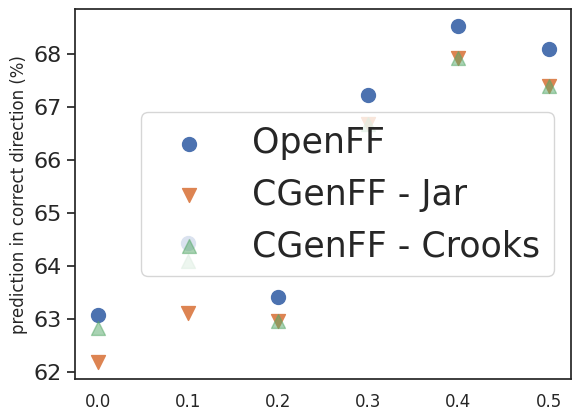

In [29]:
fig, ax1 = plt.subplots()
ax1.scatter(results.keys(),results.values(), label = "OpenFF")
ax1.scatter(results_cgenff.keys(),results_cgenff.values(),marker ="v", label = "CGenFF - Jar")
ax1.scatter(results_cgenff_crooks.keys(),results_cgenff_crooks.values(),marker ="^", label = "CGenFF - Crooks",alpha=0.5)
ax1.set_ylabel("prediction in correct direction (%)")
ax1.legend()

In [30]:
!pip install molcomplib

In [31]:
# from molcomplib import MolCompass
# compass = MolCompass()
# list_of_compounds = [smi.strip() for smi in data[" SMILES"]]
# res = np.vstack([compass(compound) for compound in list_of_compounds])

In [32]:
from molcomplib import MolCompass
import plotly.express as px

In [33]:
data = pd.read_csv("sample_data/combinedDataset.csv")
data["Crooks correction"] = np.abs(data["Crooks correction"])
data = data.sort_values(by="Crooks correction")
data = data[0:130]

molcomp = MolCompass()
df = pd.DataFrame({'smiles':[smi.strip() for smi in data[" SMILES"]]})
res = molcomp.process(df)

fig = px.scatter(res,x="x",y="y",color=np.abs(data["Crooks correction"]),hover_name=data[" SMILES"],color_continuous_scale=px.colors.sequential.Bluered)
fig.update_layout(width=800,height=600)
fig.show()

In [34]:
data = pd.read_csv("sample_data/combinedDataset.csv")
data.loc[:, "direction"] = np.nan

for index,row in data.iterrows():
    deviation_mm = (np.abs(row["dG (TF) lrc"]-row["Exp [kcal/mol]"]))
    deviation_corrected = (np.abs(row["Crooks result"]-row["Exp [kcal/mol]"]))
    if deviation_mm > deviation_corrected:
      data.loc[index, "direction"] = 1 #correct direction
    else:
      data.loc[index, "direction"] = 0 #wrong direction

In [35]:
molcomp = MolCompass()
df = pd.DataFrame({'smiles':[smi.strip() for smi in data[" SMILES"]]})
res = molcomp.process(df)

In [36]:
fig = px.scatter(res,x="x",y="y",hover_name=data[" SMILES"],color = data["direction"] )
fig.update_layout(width=800,height=600)
fig.show()